In [5]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create "honeycomb" model geometry

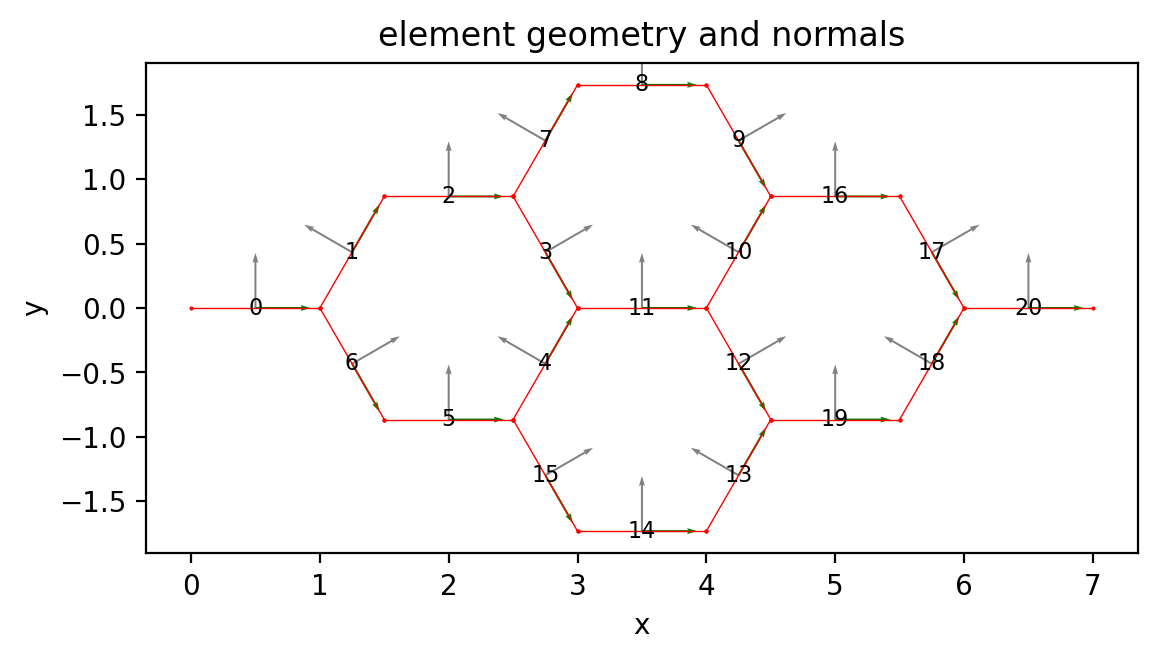

In [6]:
# Honeycomb geometry
dx = np.cos(np.deg2rad(60))
dy = np.sin(np.deg2rad(60))
els = bemcs.initialize_els()

els.x1 = np.array(
    [
        0,
        1,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        2 + dx,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        3 + 3 * dx,
        4 + 3 * dx,
        4 + 4 * dx,
        4 + 3 * dx,
        4 + 4 * dx,
    ]
)
els.y1 = np.array(
    [
        0,
        0,
        dy,
        dy,
        0,
        -dy,
        -dy,
        dy,
        2 * dy,
        2 * dy,
        dy,
        0,
        0,
        -dy,
        -2 * dy,
        -2 * dy,
        dy,
        dy,
        0,
        -dy,
        0,
    ]
)
els.x2 = np.array(
    [
        1,
        1 + dx,
        2 + dx,
        2 + 2 * dx,
        2 + dx,
        1 + dx,
        1,
        2 + 2 * dx,
        3 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        3 + 3 * dx,
        3 + 2 * dx,
        2 + 2 * dx,
        2 + dx,
        4 + 3 * dx,
        4 + 4 * dx,
        4 + 3 * dx,
        3 + 3 * dx,
        5 + 4 * dx,
    ]
)
els.y2 = np.array(
    [
        0,
        dy,
        dy,
        0,
        -dy,
        -dy,
        0,
        2 * dy,
        2 * dy,
        dy,
        0,
        0,
        -dy,
        -2 * dy,
        -2 * dy,
        -dy,
        dy,
        0,
        -dy,
        -dy,
        0,
    ]
)

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Set slip rates at element centroids
Currently this is just a linear gradient in slip with $y$.  Not sure if that's interesting enough but probably a good starting place.

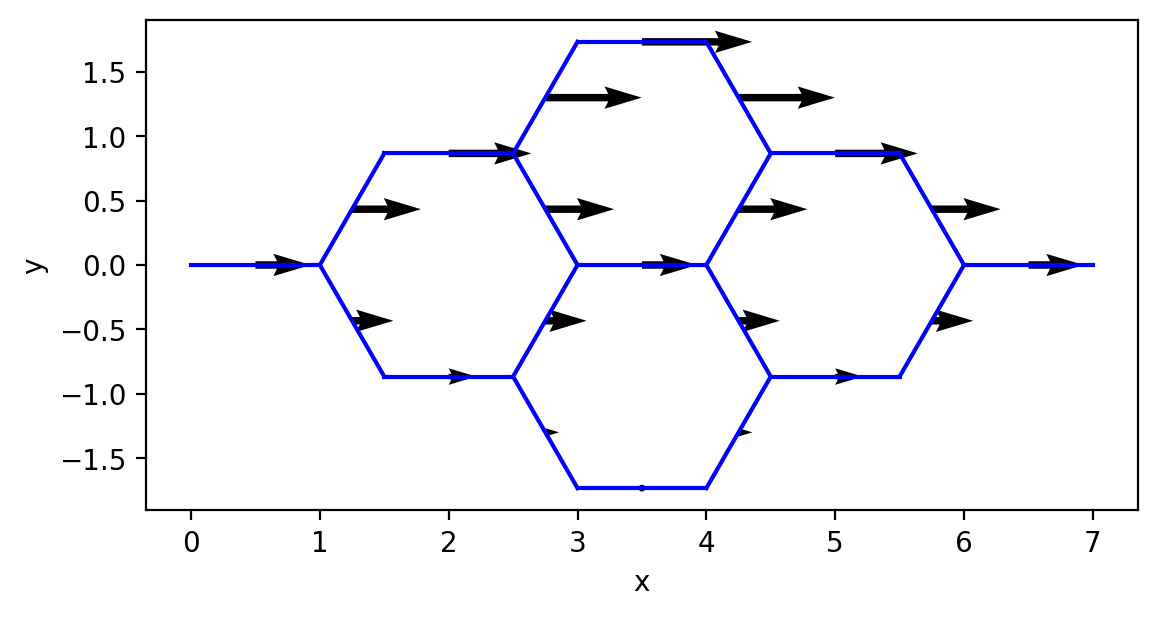

In [7]:
x_slips = np.zeros(n_els)
y_slips = np.zeros(n_els)
x_slips[0] = 0.500
x_slips[1] = 0.625
x_slips[2] = 0.750
x_slips[3] = 0.625
x_slips[4] = 0.375
x_slips[5] = 0.250
x_slips[6] = 0.375
x_slips[7] = 0.875
x_slips[8] = 1.000
x_slips[9] = 0.875
x_slips[10] = 0.625
x_slips[11] = 0.500
x_slips[12] = 0.375
x_slips[13] = 0.125
x_slips[14] = 0.000
x_slips[15] = 0.125
x_slips[16] = 0.750
x_slips[17] = 0.625
x_slips[18] = 0.375
x_slips[19] = 0.250
x_slips[20] = 0.500

plt.figure()
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "-b")
plt.quiver(els.x_centers, els.y_centers, x_slips, y_slips)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.show()

In [8]:
# first find all unique points
points = np.zeros((2 * n_els, 2))
x1y1 = np.vstack((els.x1, els.y1)).T
x2y2 = np.vstack((els.x2, els.y2)).T
points[0::2, :] = x1y1
points[1::2, :] = x2y2
nvec = np.vstack((els.x_normals, els.y_normals)).T
xmid = np.copy(els.x_centers)
ymid = np.copy(els.y_centers)
unique_points, id_unique = np.unique(points, axis=0, return_index=True)

# Find number of open, 2-overlap & triple junction nodes
index_matrix1 = []
index_matrix2 = []
index_matrix3 = []
for i in range(len(unique_points)):
    pts = unique_points[i, :].reshape(1, -1)

    # Which element(s) contains this point
    id1 = np.where(np.all(pts == x1y1, axis=1))
    id2 = np.where(np.all(pts == x2y2, axis=1))

    # The negative signs are for the triple junction equations
    # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2
    if np.size(id1) == 2:
        id_combo = np.hstack((-id1[0] * 3, id2[0] * 3 + 2))
    elif np.size(id2) == 2:
        id_combo = np.hstack((id1[0] * 3, -(id2[0] * 3 + 2)))
    else:
        id_combo = np.hstack((id1[0] * 3, id2[0] * 3 + 2))

    if np.size(id_combo) == 1:
        index_matrix1.append(id_combo)
    elif np.size(id_combo) == 2:
        index_matrix2.append(id_combo)
    elif np.size(id_combo) == 3:
        index_matrix3.append(id_combo)
    else:
        print(id_combo)
        raise ValueError("Cannot deal with more than 3 lines at a node")

print("Number of open nodes =", len(index_matrix1))
print(":", index_matrix1)
print("Number of 2-overlap nodes =", len(index_matrix2))
print(":", index_matrix2)
print("Number of triple junctions =", len(index_matrix3))
print(":", index_matrix3)

N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_matrix1)  # open node equations
N_i = 4 * len(index_matrix2)  # overlapping node equations
N_t = 6 * len(index_matrix3)  # triple junction equations

Number of open nodes = 2
: [array([0]), array([62])]
Number of 2-overlap nodes = 8
: [array([15, 20]), array([6, 5]), array([42, 47]), array([24, 23]), array([39, 44]), array([27, 26]), array([54, 59]), array([51, 50])]
Number of triple junctions = 8
: [array([ -3, -18,   2]), array([-12, -45,  17]), array([ -9, -21,   8]), array([ 33, -11, -14]), array([-30, -36,  35]), array([ 57, -38, -41]), array([ 48, -29, -32]), array([ 60, -53, -56])]
